# Introduction

In this notebook, we'll look at one application of the SVD: Latent Semantic Analysis (LSA).  Although this example is a very small and simplified implementation, it should provide you with a flavor of how the SVD can be used to expose low-dimensional structure in high-dimensional data.

# From documents to vectors

Using some vocabulary from the field, we'll be working with a collection (or *corpus*) of *documents* (or *texts*).  For our purposes, each document is just a string of English words and the corpus is an ordered list of these documents.  These strings come from the paper [here](http://lsa.colorado.edu/papers/dp1.LSAintro.pdf).  We'll be following the example introduced at the beginning of the paper.

In [1]:
documents = [
    'Human machine interface for ABC computer applications',
    'A survey of user opinion of computer system response time',
    'The EPS user interface management system',
    'System and human system engineering testing of EPS',
    'Relation of user perceived response time to error measurement',
    'The generation of random, binary, ordered trees',
    'The intersection graph of paths in trees',
    'Graph minors IV: Widths of trees and well-quasi-ordering',
    'Graph minors: A survey'
]

print('There are {} documents in the corpus.'.format(len(documents)))

There are 9 documents in the corpus.


The next step is to chop the documents into meaningful *tokens*.  In this case, we'll break each document into a list of its words.  The following function takes care of this.  It also gets rid of all punctuation and converts every word to lowercase to allow for easier comparison among documents.  In more advanced implementations, we would also [*stem*](https://en.wikipedia.org/wiki/Stemming) the words so that, for example, the words 'ordered', 'order', 'ordering', etc. would all be treated as the same token.

In [2]:
def tokenize(document):
    """
    Tokenizes a document.

    Args:
        document: A string containing the document text.

    Returns:
        A list of tokens from the document.
    """

    
    import string
    
    # remove punctuation
    document = document.translate(str.maketrans("","", string.punctuation))
    
    # convert all words to lowercase
    document = document.lower()
    
    # convert document to a list of words
    tokens = document.split(' ')
    
    return tokens

print('Tokens for each document')
print()
for document in documents:
    print(document)
    print(tokenize(document))
    print()

Tokens for each document

Human machine interface for ABC computer applications
['human', 'machine', 'interface', 'for', 'abc', 'computer', 'applications']

A survey of user opinion of computer system response time
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']

The EPS user interface management system
['the', 'eps', 'user', 'interface', 'management', 'system']

System and human system engineering testing of EPS
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'eps']

Relation of user perceived response time to error measurement
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']

The generation of random, binary, ordered trees
['the', 'generation', 'of', 'random', 'binary', 'ordered', 'trees']

The intersection graph of paths in trees
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']

Graph minors IV: Widths of trees and well-quasi-ordering
['graph', 'minors', 'iv', 'widths

Now that we've tokenized each document, we need some way to embed them into a vector space.  There are many ways to do this, but one of the simplest is to assign each unique word its own axis, then each document is assigned a vector with coordinates given by the number of times each word appears in the document.  In practice, it's useful to exclude certain words.  For example, the word 'the' tends to carry very little semantic content.  In some applications, the set of *index terms* are chosen automatically by filtering a set of *stop words* out of the set of all words in the corpus.  For this example, we'll explicitly select a set of terms to use for vectorizing the documents.  (These are exactly the terms chosen on page 10 of the paper.)

In [3]:
terms = [ 'human', 'interface', 'computer', 'user', 'system', 'response',
          'time', 'eps', 'survey', 'trees', 'graph', 'minors' ]

print('The documents will be embedded in {}-dimensional space.'.format(len(terms)))

The documents will be embedded in 12-dimensional space.


One last step before we can vectorize the documents.  We'll need a quick way to check if a word appears in the terms list and, if so, to determine where in the list it occurs.  In Python, this can be efficiently accomplished by creating a dictionary object that maps each term to its index, as follows.

In [4]:
term_id = { term:i for i,term in enumerate(terms) }

for t in ('human', 'hamburger', 'salad', 'survey'):
    if t in term_id:
        print('{} is entry {} in the terms list'.format(t,term_id[t]))
    else:
        print('{} is not a term in the list'.format(t))
    print

human is entry 0 in the terms list
hamburger is not a term in the list
salad is not a term in the list
survey is entry 8 in the terms list


Now we can create the vectorizer.  For each document, it should assign a vector $v$ with the property that $v_i$ is the number of times term $i$ appears in the document.

## 💻 Exercise

Implement the vectorize function below.

In [5]:
def vectorize(document,terms,term_id):
    """
    Converts a document string into a vector.

    Args:
        document : The document string.
        terms    : The list of index terms.
        term_id  : Dictionary mapping each term to its index in 'terms'

    Returns:
        v : A numpy array with the property that v[i] contains the number
            of times terms[i] appears in the document.
    """
    
    import numpy as np

    # intialize a zero vector
    v = np.zeros(len(terms))
    
    # tokenize the document
    tokens = tokenize(document)
    
    # YOUR CODE HERE
    for token in tokens:
        if token in term_id:
            v[term_id[token]] += 1
    return v

In [6]:
#
# small batch of multi-word tests
#
import numpy as np
from numpy.testing import assert_equal

test_documents = [ 'no terms here', 'human human crazy human', 'survey graph survey monkey survey' ]
test_answers   = [
    np.array( [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] ),
    np.array( [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] ),
    np.array( [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 0.] )
]
for i in range(len(test_documents)):
    assert_equal( vectorize(test_documents[i],terms,term_id), test_answers[i] )
    
#
# test that all one-word documents get the right vector
#
for i,t in enumerate(terms):
    true    = np.zeros(len(terms))
    true[i] = 1.
    assert_equal( vectorize(terms[i],terms,term_id), true )
    
print('All tests passed!')

All tests passed!


# The occurrence matrix

Suppose $m$ is the number of terms and $n$ is the number of documents.  The occurrence matrix $X$ is the $m\times n$ matrix with $X_{ij}$ equal to the number of times term $i$ shows up in document $j$.

## 💻 Exercise

Use your <tt>vectorize</tt> function to implement the following function to build the occurrence matrix.

In [7]:
def occurrence_matrix(documents,terms,term_id):
    """
    Forms the occurrence matrix for a corpus of documents.

    Args:
        documents : Iterable of document strings.
        terms     : The list of index terms.
        term_id   : Dictionary mapping each term to its index in 'terms'

    Returns:
        X : A term-by-document numpy array where each column is the occurrence vector of
            the corresponding document.
    """

    
    import numpy as np
    
    # initialize empty matrix
    m, n = len(terms), len(documents)
    X = np.zeros((m,n))
    
    # YOUR CODE HERE
    for j, document in enumerate(documents):
        X[:,j] = vectorize(document,terms,term_id)
    return X

In [8]:
#
# small test
#
test_documents = ['a b c', 'a c d', 'c d f c']
test_terms = [ 'a', 'b', 'c', 'd' ]
test_term_id = { test_terms[i] : i for i in range(len(test_terms)) }
X_true = np.array([[1., 1., 0.], [1., 0., 0.], [1., 1., 2.], [0., 1., 1.]])
X = occurrence_matrix(test_documents,test_terms,test_term_id)
assert_equal(X,X_true)

#
# make sure the code is using vectorize (i.e., not a copy/paste job)
#
zz_vectorize = vectorize
del vectorize
try:
    occurrence_matrix(documents,terms,term_id)
except NameError:
    pass
else:
    raise AssertionError('occurrence_matrix does not use vectorize')
finally:
    vectorize = zz_vectorize
    del zz_vectorize
    
print('All tests passed!')

All tests passed!


Here's a handy function that will print out the occurrence matrix.  The table it prints should match the one in the paper.

In [9]:
def print_occurrence_matrix(X,terms):
    m,n = X.shape
    print(' '*10, end='')
    for j in range(n):
        print('{:5} '.format(j), end='')
    print()
    for i in range(m):
        print('{:10}'.format(terms[i]), end='')
        for j in range(n):
            print('{: .2f} '.format(X[i,j]), end='')
        print()

X = occurrence_matrix( documents, terms, term_id )
print_occurrence_matrix(X,terms)

              0     1     2     3     4     5     6     7     8 
human      1.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00 
interface  1.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
computer   1.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
user       0.00  1.00  1.00  0.00  1.00  0.00  0.00  0.00  0.00 
system     0.00  1.00  1.00  2.00  0.00  0.00  0.00  0.00  0.00 
response   0.00  1.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
time       0.00  1.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00 
eps        0.00  0.00  1.00  1.00  0.00  0.00  0.00  0.00  0.00 
survey     0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00 
trees      0.00  0.00  0.00  0.00  0.00  1.00  1.00  1.00  0.00 
graph      0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00  1.00 
minors     0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00 


# Computing similarity

The occurrence matrix provides us a vector representing each document (the columns of $X$), as well as a vector representing each word (the rows of $X$).  For example, document 0 in the corpus is represented as the vector

$$ [1\; 1\; 1\; 0\; 0\; 0\; 0\; 0\; 0\; 0\; 0\; 0 ]^T $$

while the term 'human' is represented as the vector

$$ [ 1\; 0\; 0\; 1\; 0\; 0\; 0\; 0\; 0 ]^T. $$

One useful thing we might want to be able to do is to compare two documents or two terms for similarity.  A common technique is to use a measure called *cosine similarity*, which is based on the cosine of the angle between the two vector representations.  Given two vectors $x$ and $y$, the cosine similarity between $x$ and $y$ is computed as

$$
    \text{similarity}(x,y) = \frac{x^Ty}{\|x\|\,\|y\|}.
$$

## 💻 Exercise

Implement the cosine similarity function below.  Make sure it passes all tests before continuing.

In [10]:
def cosine_similarity(x,y):
    """
    Computes the cosine similarity between two vectors.

    Args:
        x: First vector as a numpy array.
        y: Second vector as a numpy array.

    Returns:
        The cosine similarity between x and y.
    """

    # YOUR CODE HERE
    import numpy as np
    return x.dot(y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [11]:
# tests for cosine similarity
from numpy.testing import assert_almost_equal
import numpy as np

tests = (([1,0],[0,1],0),([1,0,0],[3,0,0],1),([1,1,1,1],[1,1,1,0],np.sqrt(3)/2,),
         ([-1,2,3,-4],[0,-1,0,5],-11./np.sqrt(195)))

for x,y,sim in tests:
    x = np.array(x)
    y = np.array(y)
    assert_almost_equal(cosine_similarity(x,y),sim)
    
print('All tests passed!')

All tests passed!


The following code cell shows a way of visualizing the pairwise similarity among our documents.

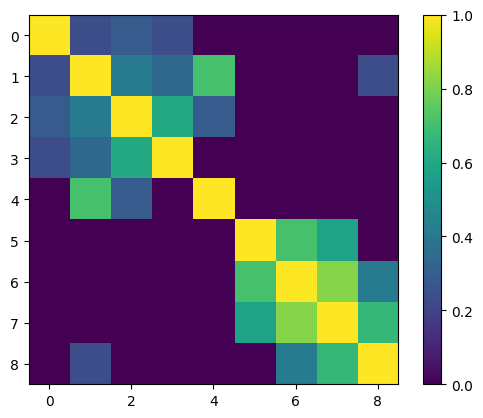

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

m,n = X.shape
sim = np.zeros((n,n))
for i in range(n):
    for j in range(i,n):
        sim[i,j] = cosine_similarity(X[:,i],X[:,j])
        sim[j,i] = sim[i,j]
        
plt.imshow(sim,interpolation='nearest',cmap='viridis')
plt.colorbar();

The colors of the square pixels in the image show the values of the cosine similarity among the documents.  The ones on the diagonal show the obvious observation that every vector is parallel to itself.  The block-diagonal structure of the matrix suggests that the documents have already been ordered into two groups of similar documents.  The following cell mixes up the order of the documents to give a more realistic picture.  (Just so you don't get the impression that a typical document-document similarity plot will have a nice block-diagonal structure.)

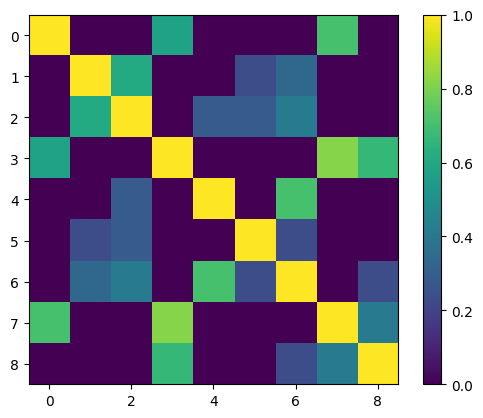

In [13]:
m,n = X.shape
np.random.seed(7182001)
Z = X[:,np.random.permutation(n)]
sim = np.zeros((n,n))
for i in range(n):
    for j in range(i,n):
        sim[i,j] = cosine_similarity(Z[:,i],Z[:,j])
        sim[j,i] = sim[i,j]
        
plt.imshow(sim,interpolation='nearest',cmap='viridis')
plt.colorbar();

The following cell shows the similarity among terms.  You'll notice again a strong suggestion that the authors of the paper have already arranged the terms into two groups for us.

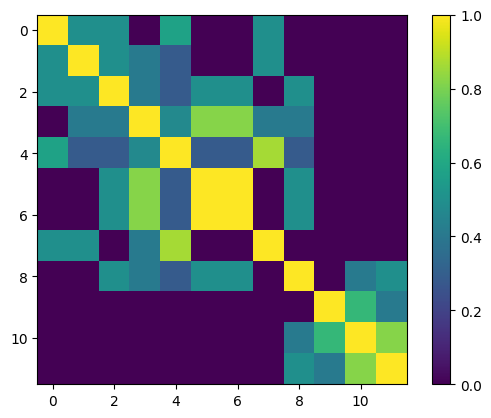

In [14]:
m,n = X.shape
sim = np.zeros((m,m))
for i in range(m):
    for j in range(i,m):
        sim[i,j] = cosine_similarity(X[i,:],X[j,:])
        sim[j,i] = sim[i,j]
        
plt.imshow(sim,interpolation='nearest',cmap='viridis')
plt.colorbar();

Inspired by the paper, let's take a look at the similarity between term 0 ('human') and term 3 ('user').  Notice that the similarity value is 0 and, indeed, by inspecting $X$ we can verify that the two term vectors are orthogonal.  In a sense, this is hardly surprising.  We have a corpus of 9 documents vectorized by 12 terms.  The fact that there is no obvious connection between 'human' and 'user' can easily be attributed to a lack of sufficient information.  However, rather than just leave off with this explanation, the authors make an interesting claim: that the SVD can uncover a connection between the terms.  Although it can be a little tricky to formalize the argument in a purely mathematical context, the basic idea appears to be related to the "curse of dimensionality".

# The curse of dimensionality

The "curse of dimensionality" is a phrase that is used by people working in big data to signify a fundamental difficulty in the field: high-dimensional spaces are weird.  By weird, we mean that things that seem intuitive in our usual 3-dimensional world are not so obvious and sometimes even *wrong* in higher dimensions.  A bunch of examples can be found in [this paper](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180lecture1.pdf), including the "orange peel" problem.  In 3D, when you remove a thin shell (the orange peel) from a sphere (the orange), you still have a lot of volume left to... eat.  For a high-dimensional orange, though, once you remove the peel, there's almost nothing left.  In more mathematical terms, the volume of a high-dimensional sphere is concentrated near its boundary.

Another example of weirdness has to do with the angle between random directions.  Suppose we pick two directions in $d$-dimensional space at random.  What would you expect the angle between these two directions to be?  As the following simulation shows, the answer depends on $d$.

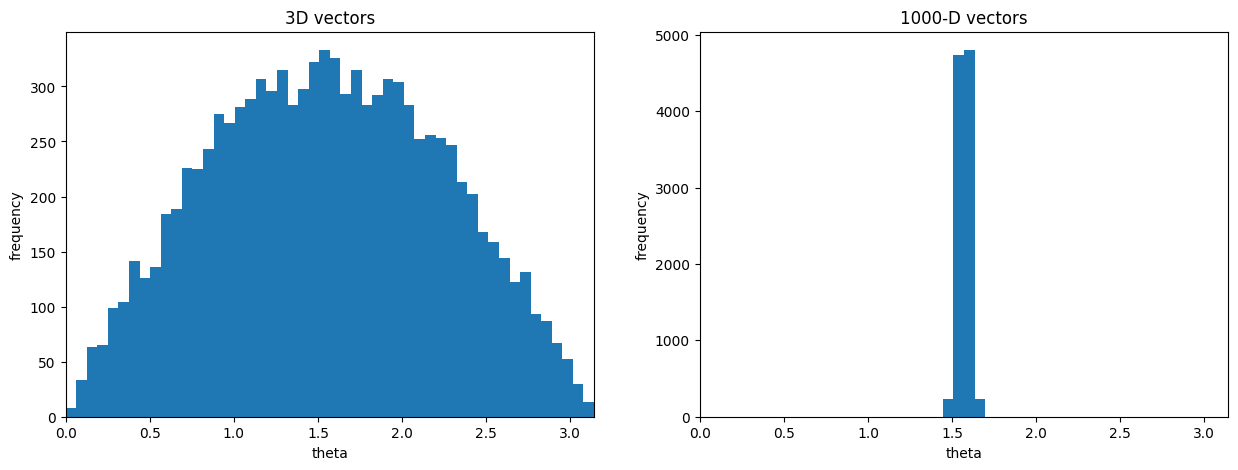

In [15]:
import numpy as np

# number of direction pairs to choose
n_samples = 10000

# seed the random number generator so we all see the same thing
np.random.seed(18477718)

# places to store the samples
samples_low_d = np.zeros(n_samples)
samples_high_d = np.zeros(n_samples)

# loop to collect samples
for i in range(n_samples):
    
    # two random vectors in low-D
    x = np.random.randn(3)
    y = np.random.randn(3)
    samples_low_d[i] = np.arccos(cosine_similarity(x,y))

    # two random vectors in high-D
    x = np.random.randn(1000)
    y = np.random.randn(1000)
    samples_high_d[i] = np.arccos(cosine_similarity(x,y))

# plot the cosine histograms
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(samples_low_d,bins=50,range=[0,np.pi]);
plt.xlabel('theta')
plt.ylabel('frequency')
plt.title('3D vectors')
plt.xlim([0,np.pi])

plt.subplot(1,2,2)
plt.hist(samples_high_d,bins=50,range=[0,np.pi])
plt.xlabel('theta')
plt.ylabel('frequency')
plt.title('1000-D vectors')
plt.xlim([0,np.pi]);

If you pick two random directions 3D, the distribution of angles is fairly spread out.  The mean appears to be $\pi/2$, but nearly-parallel directions are quite possible.  In high dimensions, though, the two directions are almost certainly going to be nearly perpendicular.  This is a problem for the following reason.

We often analyze a dataset in order to infer relationships among variables.  When we do this, we are essentially hoping that our observations can be explained using only a fairly small number of variables.  However, when we're sampling the data "in the wild," we don't know which variables these are.  So, we just collect everything we can get our hands on.  The problem with this approach is that, by sampling irrelevant data, we are polluting our dataset with a bunch of random noise.  Imagine, for example, taking a nice 2D dataset where the relationships among variables is clear and then embedding this data into 100D and adding random noise in the 98 irrelevant directions.  Suddenly, vectors that lined up perfectly in the 2D data are almost orthogonal in 100D.  In a sense, there's simply way too much "room" in high-dimensional spaces, making it difficult to analyze data in them.  So a huge part of analyzing big data is to reduce the number of dimensions (hopefully by keeping important dimensional data while discarding unimportant data).

# Dimension reduction and the SVD

One of the simplest (and most widely used) techniques for dimension reduction is linear projection.  Given data represented as vectors in $d$-dimensional space, we choose a $k$-dimensional subspace, project our data there, and then analyze the lower-dimensional result.  But how do we pick the subspace, or $k$ for that matter?  In general, these aren't easy questions.  There is a lot of trial-and-error involved, and each discipline tends to develop its own conventions by repeated testing and tweaking over time.

The technique used in the LSA paper is to use the SVD to pick out the important dimensions to use.  Without getting too deep into the theory (and speculation), here's the basic idea: pick a $k$ (The authors use $k=2$ for the tiny data set we've been working with; in real applications you should imagine $k$ in the hundreds or maybe thousands.) and replace the occurrence matrix $X$ by its best rank-k approximation $X_k$.  The following cells give a very simple implementation of this idea followed by a test to make sure the code reproduces the $X_k$ from the paper.  (In the real world, we would likely store the vectors $U_k$ and $\Sigma_k V_k^T$ rather than compute $X_k$ explicitly.)

In [16]:
def low_rank_approx(X,k):
    """
    Produces a low-rank approximation of a matrix.

    Args:
        X: The matrix to approximate (a numpy array).
        k: The target rank.

    Returns:
        A numpy array holding the best rank-k approximation to X.

    """

    
    from numpy.linalg import svd

    # compute the SVD
    U,S,VT = svd(X)
    
    # restrict to rank k
    U = U[:,:k]
    S = S[:k]
    VT = VT[:k,:]
    
    return U.dot(np.diag(S)).dot(VT)

In [17]:
Xk = low_rank_approx(X,2)

# here is the reduced matrix given in the paper
# (it only has two digits of accuracy)
Xk_true = np.array( [
    [ 0.16, 0.40, 0.38, 0.47, 0.18, -0.05, -0.12, -0.16, -0.09 ],
    [ 0.14, 0.37, 0.33, 0.40, 0.16, -0.03, -0.07, -0.10, -0.04 ],
    [ 0.15, 0.51, 0.36, 0.41, 0.24, 0.02, 0.06, 0.09, 0.12 ],
    [ 0.26, 0.84, 0.61, 0.70, 0.39, 0.03, 0.08, 0.12, 0.19 ],
    [ 0.45, 1.23, 1.05, 1.27, 0.56, -0.07, -0.15, -0.21, -0.05 ],
    [ 0.16, 0.58, 0.38, 0.42, 0.28, 0.06, 0.13, 0.19, 0.22 ],
    [ 0.16, 0.58, 0.38, 0.42, 0.28, 0.06, 0.13, 0.19, 0.22 ],
    [ 0.22, 0.55, 0.51, 0.63, 0.24, -0.07, -0.14, -0.20, -0.11 ],
    [ 0.10, 0.53, 0.23, 0.21, 0.27, 0.14, 0.31, 0.44, 0.42 ],
    [ -0.06, 0.23, -0.14, -0.27, 0.14, 0.24, 0.55, 0.77, 0.66 ],
    [ -0.06, 0.34, -0.15, -0.30, 0.20, 0.31, 0.69, 0.98, 0.85 ],
    [ -0.04, 0.25, -0.10, -0.21, 0.15, 0.22, 0.50, 0.71, 0.62 ] ] )

# check the relative error
assert( np.linalg.norm(Xk-Xk_true)/np.linalg.norm(Xk_true) < 1e-2 )

print('The X_k matrix is correct.')

The X_k matrix is correct.


The following table shows the approximate occurrence matrix.

In [18]:
print_occurrence_matrix(Xk,terms)

              0     1     2     3     4     5     6     7     8 
human      0.16  0.40  0.38  0.47  0.18 -0.05 -0.12 -0.16 -0.09 
interface  0.14  0.37  0.33  0.40  0.16 -0.03 -0.07 -0.10 -0.04 
computer   0.15  0.51  0.36  0.41  0.24  0.02  0.06  0.09  0.12 
user       0.26  0.84  0.61  0.70  0.39  0.03  0.08  0.12  0.19 
system     0.45  1.23  1.05  1.27  0.56 -0.07 -0.15 -0.21 -0.05 
response   0.16  0.58  0.38  0.42  0.28  0.06  0.13  0.19  0.22 
time       0.16  0.58  0.38  0.42  0.28  0.06  0.13  0.19  0.22 
eps        0.22  0.55  0.51  0.63  0.24 -0.07 -0.14 -0.20 -0.11 
survey     0.10  0.53  0.23  0.21  0.27  0.14  0.31  0.44  0.42 
trees     -0.06  0.23 -0.14 -0.27  0.14  0.24  0.55  0.77  0.66 
graph     -0.06  0.34 -0.15 -0.30  0.20  0.31  0.69  0.98  0.85 
minors    -0.04  0.25 -0.10 -0.21  0.15  0.22  0.50  0.71  0.62 


Note that it's trickier to understand exactly what these numbers mean than it was before.  What do fractional or negative occurrences mean?  Over time, people working with LSA developed some intuitive ways of interpreting these numbers.  (Take a look at p. 12 of the paper, for example.)  Although it's interesting, we don't really need to develop the same intuition in order to appreciate what happens next.  Compare the following term-term similarity matrices.  The first is the one we saw before.  The second is the result of using the SVD to project the data into 2 dimensions first.

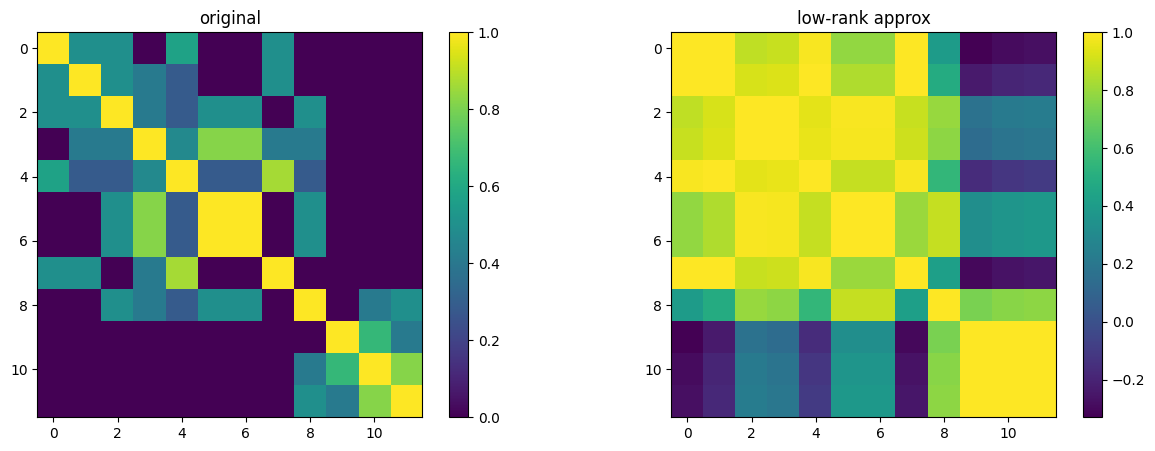

In [19]:
m,n = X.shape
sim = np.zeros((m,m))
sim_k = np.zeros((m,m))
for i in range(m):
    for j in range(i,m):
        sim[i,j] = cosine_similarity(X[i,:],X[j,:])
        sim[j,i] = sim[i,j]
        sim_k[i,j] = cosine_similarity(Xk[i,:],Xk[j,:])
        sim_k[j,i] = sim_k[i,j]
        
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(sim,interpolation='nearest',cmap='viridis')
plt.title('original')
plt.colorbar();

plt.subplot(1,2,2)
plt.imshow(sim_k,interpolation='nearest',cmap='viridis')
plt.title('low-rank approx')
plt.colorbar();

# Learning more about LSA

The authors of the LSA paper suggest that the figure on the right above demonstrates the power of using the SVD for semantic analysis.  By throwing out some irrelevant dimensions, we are able to detect a relationship between the terms 'human' and 'user' within the corpus.  Whether this is true is somewhat academic; it's nearly impossible to make an inference from a single observation.  Nonetheless, it does give us something to think about.  Moreover, numerous tests of this technique (and some significant refinements) on much larger corpora have generated a body of evidence that suggest that SVD-based LSA can be useful in certain applications.  If you're interested, you can read more of the paper and/or search the web for 'latent semantic analysis'.

# Learning more about projections

The theory of projections and its relationship to the SVD is a rich subject that certainly can't be covered in one Jupyter notebook.  Here's a taste of some of that theory that will help you with the quiz for this module.  First, a quick review of some linear algebra.

## Four fundamental subspaces

Given a matrix $A\in\mathbb{R}^{m\times n}$, the *range* of $A$, $R(A)$, and *nullspace* of $A$, $N(A)$, are defined as

$$
    R(A) = \{Ax : x\in\mathbb{R}^m\}\qquad\text{and}\qquad
    N(A) = \{x\in\mathbb{R}^n : Ax = 0 \}.
$$

**Note:** As with many things in linear algebra, there is no universally accepted convention for the notation of range and nullspace.  For example, some authors will denote the range of $A$ as $\text{rng}(A)$ or $\text{ran}(A)$.  Others will call it the *column space* and denote it $\text{col}(A)$.  The nullspace might be denoted $\text{nul}(A)$ or $\text{null}(A)$.  Some authors call it the *kernel* and denote it $\text{ker}(A)$.  It's important to be aware of these differences and to make sure you know what concept is being talked about when you switch between papers and books.

A standard exercise in undergrad linear algebra is to verify that $R(A)$ is a subspace of $\mathbb{R}^n$ and $N(A)$ is a subspace of $\mathbb{R}^m$.  Given any subspace $S$ of a vector space, $\mathbb{R}^n$ say, the *orthogonal subspace* $S^\perp$ (often called "S perp") is defined as

$$
    S^\perp = \{ x\in\mathbb{R}^n : x^Ty = 0\;\forall y\in S\}.
$$

Again, verifying that $S^\perp$ is a subspace is a standard exercise.  Typically, you would also see the fact that $\mathbb{R}^n=S\oplus S^\perp$.  (If you need to find this in a book to review, the term you are looking for is "direct sum.")

A modern view of linear algebra that has emerged is that of the "Four fundamental subspaces" of a matrix.  Here is a nice set of [lecture notes](http://math.mit.edu/classes/18.095/2016IAP/lec2/SVD_Notes.pdf) on the topic.  It's a beautiful idea that can be explained through the SVD as follows.

Recall that if $A$ has rank $r$, then we can write the SVD of $A$ in a few different ways.  At the two extremes are the most compact form and the full form:

$$
    A = U\Sigma V^T = [U_r\;\tilde{U}]
    \begin{bmatrix}
    \Sigma_r & 0 \\ 0 & 0
    \end{bmatrix}
    [V_r\;\tilde{V}]^T
    = U_r\Sigma_r V_r^T.
$$

As explained in the notes, the columns of the matrices $U_r$, $\tilde{U}$, $V_r$ and $\tilde{V}$ all span a different important subspace related to the matrices $A$ and $A^T$:

$$
\begin{gather*}
    R(A)       = \text{span } U_r = N(A^T)^\perp\\
    R(A)^\perp = \text{span } \tilde{U} = N(A^T)\\
    N(A)       = \text{span } \tilde{V} = R(A^T)^\perp\\
    N(A)^\perp = \text{span } V_r = R(A^T).
\end{gather*}
$$

## Orthogonal projection

Given a subspace $S$ of $\mathbb{R}^n$ and a vector $x\in\mathbb{R}^n$, the goal of orthogonal projection can be expressed in optimization form as

$$
\begin{align*}
    \text{minimize}&\quad \|y-x\|\\
    \text{subject to}&\quad y\in S.
\end{align*}
$$

In words, we want to find the vector $y$ in $S$ that is closest (in the 2-norm sense) to the given vector $x$.  If we have an orthonormal basis for $S$, there is a very simple formula for finding the projection.  Suppose $S$ has dimension $k$ and let $U\in\mathbb{R}^{n\times k}$ have columns given by an orthonormal basis for $S$. (In other words, $S=\text{span }U$ and $U^TU=I_{k\times k}$.)  Then the orthogonal projection of $x$ onto $S$ is given by $y=UU^Tx$.  The matrix $P=UU^T$ is called the projection matrix.  Watch the following video to get a better understanding of how projections work.

<center>
<table>
    <tr>
        <td>
            <a href="https://youtu.be/1Mqq2rLV910">
                <img src="https://img.youtube.com/vi/1Mqq2rLV910/hqdefault.jpg"><br>
                Projections and Orthogonal Matrices
            </a>
        </td>
    </tr>
</table>
</center>


Looking back at the relationship between the SVD and the four fundamental subspaces, we can find some useful formulas:
- the matrix $U_rU_r^T$ is the orthogonal projection onto $R(A)$,
- the matrix $\tilde{V}\tilde{V}^T$ is the orthogonal projection onto $N(A)$,
- and so on.

Moreover, if $P$ is the orthogonal projection matrix onto the subspace $S$, then $I-P$ is the orthogonal projection matrix onto $S^\perp$.  So another way to write the projection onto $N(A)$ is $I-V_rV_r^T$.

## The Moore-Penrose Pseudoinverse

While we're on the topic of projections, it's also a good idea to recall the pseudoinverse operator.  Given a matrix $A\in\mathbb{R}^{m\times n}$, the pseudoinverse is the operator $A^+\in\mathbb{R}^{n\times m}$ with the following two properties.

1. For any $b\in\mathbb{R}^m$, the vector $A^+b$ minimizes $\|Ax-b\|_2$ over all $x\in\mathbb{R}^n$.
2. Among all the $x\in\mathbb{R}^n$ that minimize $\|Ax-b\|_2$, $A^+b$ is the one with smallest 2-norm.

There are many useful ways of viewing the pseudoinverse.  One way, that relies heavily on projection matrices, is described in the following video.

<center>
<table>
    <tr>
        <td>
            <a href="https://youtu.be/RsX9ILHGAaQ">
                <img src="https://img.youtube.com/vi/RsX9ILHGAaQ/hqdefault.jpg"><br>
                SVD, Projection and the Pseudoinverse
            </a>
        </td>
    </tr>
</table>
</center>